# Deep Learning Assignment 1 - Problem 1
## Saber Sheybani
See the report file for documentation and discussion.

In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="5"

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

batch_size=128
learning_rate=0.01
epochs=8
log_interval=50
test_batch_size=1024


## Question 1,2

In [2]:
# Load data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/opt/e533/MNIST',
                    train=True, download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
                    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/opt/e533/MNIST',
                    train=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
                    batch_size=test_batch_size, shuffle=True)

In [5]:
# Examining the dataset
#data, target=train_loader.dataset[707]
#data_num=data.numpy().squeeze()
#plt.imshow(data_num)
#target

In [167]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.outl = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.outl(x)
        return F.log_softmax(x)
        #return F.log_softmax(x,dim=0)

In [7]:
net = Net()
print(net)
# create a stochastic gradient descent optimizer
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
# create a negative log-likelihood loss function
criterion = nn.NLLLoss()


Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (outl): Linear(in_features=1024, out_features=10, bias=True)
)


In [ ]:
# run the main training loop
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
        data = data.view(-1, 28*28)
        optimizer.zero_grad()
        net_out = net(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.data[0]))

## Problem 1 - Question 3

In [ ]:
# run a test loop
example_num = 1024
batch_num = example_num/batch_size # Limiting the number of test examples

test_loss = 0
correct = 0

for batch_idx, (img_data, target) in enumerate(test_loader):
    img_data, target = Variable(img_data, volatile=True), Variable(target)
    img_data = img_data.view(-1, 28 * 28)
    net_out = net(img_data)
    # sum up batch loss
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
    correct += pred.eq(target.data).sum()
    if batch_idx == batch_num-1:
        break
    
    
#test_loss /= len(test_loader.dataset)
test_loss /= example_num
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, example_num,
100. * correct / example_num))

In [143]:
# Convert and save the selected test set.
data_np = img_data.data.numpy().reshape((-1, 28, 28))
pred_np = pred.numpy().squeeze()

In [144]:
# Extract the image index for each class.
img_idx_arr = np.zeros([10, 10], dtype=int)

for i in range(10):
    img_idx_arr[i,:] = np.argwhere(pred_np==i).squeeze()[:10]

[]

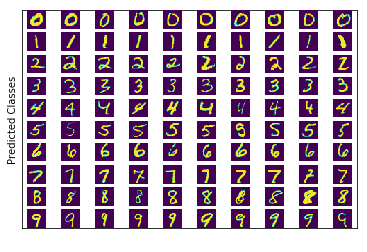

In [166]:
# plot the result
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(10):
    for j in range(10):        
        fig.add_subplot(10,10,10*i+(j+1))
        plt.imshow(data_np[img_idx_arr[i,j],...])
        plt.axis('off')
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks([])
ax.set_ylabel('Predicted Classes')

## Problem 1 - Question 4
Now we repeat it for the last hidden layer

In [3]:
# We need a new network class that returns the output of all the layers, consuming more memory. 

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.outl = nn.Linear(1024, 10)

    def forward(self, x):
        out1 = F.relu(self.fc1(x))
        out2 = F.relu(self.fc2(out1))
        out3 = F.relu(self.fc3(out2))
        out4 = F.relu(self.fc4(out3))
        out5 = F.relu(self.fc5(out4))
        y = self.outl(out5)
        return F.log_softmax(y, dim=0), out5, out4, out3, out2, out1
        #return F.log_softmax(x,dim=0)

In [4]:
net = Net2()
# create a stochastic gradient descent optimizer
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
# create a negative log-likelihood loss function
criterion = nn.NLLLoss()


In [ ]:
# run the main training loop
for epoch in range(epochs):
    for batch_idx, (img_data, target) in enumerate(train_loader):
        img_data, target = Variable(img_data), Variable(target)
        # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
        img_data = img_data.view(-1, 28*28)
        optimizer.zero_grad()
        net_out, _, _,_,_,_ = net(img_data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(img_data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.data[0]))

In [ ]:
# run a test loop
example_num = 1024
batch_num = example_num/batch_size # Limiting the number of test examples


test_loss = 0
correct = 0

for batch_idx, (img_data, target) in enumerate(test_loader):
    img_data, target = Variable(img_data, volatile=True), Variable(target)
    img_data = img_data.view(-1, 28 * 28)
    net_out, l5_out, _,_,_,_ = net(img_data)
    # sum up batch loss
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
    correct += pred.eq(target.data).sum()
    if batch_idx == batch_num-1:
        break
    
    
#test_loss /= len(test_loader.dataset)
test_loss /= example_num
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, example_num,
100. * correct / example_num))

In [36]:
# Convert and save the selected test set.
data_np = img_data.data.numpy().reshape((-1, 28, 28))
l5_out_np=l5_out.data.numpy() # The rows correspond to examples and the columns correspond to features.

Text(0,0.5,'Frequency of Being the Maximum')

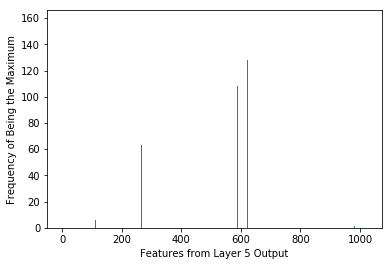

In [51]:
l5_pred = np.argmax(l5_out_np, axis=1) # vector, each element corresponds to an example. 
# and it tells which feature best represents the example.
plt.hist(l5_pred,bins=range(1024))
plt.xlabel("Features from Layer 5 Output")
plt.ylabel("Frequency of Being the Maximum")

In [67]:
# Extract the image index for each class.
img_idx_arr = np.zeros([10, 10], dtype=int)

# Selected features: The top 10 most frequent
feature_num = np.argsort(np.histogram(l5_pred, bins=range(1024))[0])[1013:]
#len(np.argwhere(pred_np==i)[:10])
for i in range(10):
    img_idx_arr[i,:] = np.argwhere(l5_pred==feature_num[i]).squeeze()[:10]

Text(0,0.5,'Predicted Classes by Layer 5')

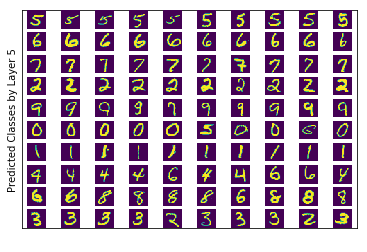

In [69]:
# plot the result
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(10):
    for j in range(10):        
        fig.add_subplot(10,10,10*i+(j+1))
        plt.imshow(data_np[img_idx_arr[i,j],...])
        plt.axis('off')
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks([])
ax.set_ylabel('Predicted Classes by Layer 5')

### 1-4 Repeat for layer 2

In [76]:
# run a test loop
example_num = 1024
batch_num = example_num/batch_size # Limiting the number of test examples

test_loss = 0
correct = 0

for batch_idx, (img_data, target) in enumerate(test_loader):
    img_data, target = Variable(img_data, volatile=True), Variable(target)
    img_data = img_data.view(-1, 28 * 28)
    net_out, _, _,_,l2_out,_ = net(img_data)
    # sum up batch loss
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
    correct += pred.eq(target.data).sum()
    if batch_idx == batch_num-1:
        break
    
    
#test_loss /= len(test_loader.dataset)
test_loss /= example_num
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, example_num,
100. * correct / example_num))



Test set: Average loss: 0.0046, Accuracy: 997/1024 (97%)



In [77]:
data_np = img_data.data.numpy().reshape((-1, 28, 28))
l2_out_np=l2_out.data.numpy() # The rows correspond to examples and the columns correspond to features.
l2_pred = np.argmax(l2_out_np, axis=1) # vector, each element corresponds to an example. 

Text(0,0.5,'Predicted Classes by Layer 5')

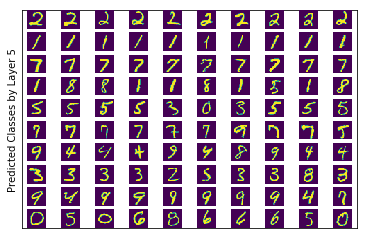

In [78]:
# Extract the image index for each class.
img_idx_arr = np.zeros([10, 10], dtype=int)

# Selected features: The top 10 most frequent
feature_num = np.argsort(np.histogram(l2_pred, bins=range(1024))[0])[1013:]
for i in range(10):
    img_idx_arr[i,:] = np.argwhere(l2_pred==feature_num[i]).squeeze()[:10]
    
# plot the result
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(10):
    for j in range(10):        
        fig.add_subplot(10,10,10*i+(j+1))
        plt.imshow(data_np[img_idx_arr[i,j],...])
        plt.axis('off')
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks([])
ax.set_ylabel('Predicted Classes by Layer 5')

## Problem 1 - Question 5,6

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

example_num = 1024
batch_num = example_num/test_batch_size # Limiting the number of test examples

In [15]:
# Load some test data and reshape it
for batch_idx, (img_data, target) in enumerate(test_loader):
    if batch_idx == batch_num-1:
        break
img_data = img_data.numpy().reshape([-1, 28*28])
target = target.numpy()

### PCA and tSNE on Input Data

In [53]:
# Reduce using PCA
pca = PCA(n_components=2)
pca.fit(img_data)
re_data_pca = pca.transform(img_data)

# Reduce using tSNE
re_data_tsne = TSNE(n_components=2).fit_transform(img_data)

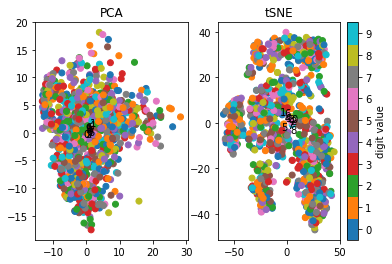

In [58]:
ax = plt.subplot("121")
ax.set_title("PCA")

plt.scatter(re_data_pca[:,0], re_data_pca[:,1], c=target_np, cmap=plt.cm.get_cmap('tab10', 10))
#plt.colorbar(ticks=range(10), label='digit value')
#plt.clim(-0.5, 9.5)
for i in range(10):
    plt.text(re_data_pca[target_np == i, 0].mean(),
            re_data_pca[target_np == i, 1].mean(),
            str(i))
    
ax = plt.subplot("122")
ax.set_title("tSNE")

plt.scatter(re_data_tsne[:,0], re_data_tsne[:,1], c=target_np, cmap=plt.cm.get_cmap('tab10', 10))
plt.colorbar(ticks=range(10), label='digit value')
plt.clim(-0.5, 9.5)
for i in range(10):
    plt.text(re_data_tsne[target_np == i, 0].mean(),
            re_data_tsne[target_np == i, 1].mean(),
            str(i))
#plt.savefig('1-6.pdf',dpi=400, format='pdf')

## Problem 1 - Question 7 - Dimensionality Reduction on First Hidden Layer

In [60]:
# run a test loop
example_num = 1024
batch_num = example_num/test_batch_size # Limiting the number of test examples


test_loss = 0
correct = 0

for batch_idx, (img_data, target) in enumerate(test_loader):
    img_data, target = Variable(img_data, volatile=True), Variable(target)
    img_data = img_data.view(-1, 28 * 28)
    net_out, _,_,_,_,l1_out = net(img_data)
    # sum up batch loss
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
    correct += pred.eq(target.data).sum()
    if batch_idx == batch_num-1:
        break
    
    
#test_loss /= len(test_loader.dataset)
test_loss /= example_num
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, example_num,
100. * correct / example_num))



Test set: Average loss: 0.0046, Accuracy: 1005/1024 (98%)



In [61]:
l1_out_np = l1_out.data.numpy()
target_np = target.data.numpy()

# Reduce using PCA
pca = PCA(n_components=2)
pca.fit(l1_out_np)
re_data_pca = pca.transform(l1_out_np)

# Reduce using tSNE
re_data_tsne = TSNE(n_components=2).fit_transform(l1_out_np)

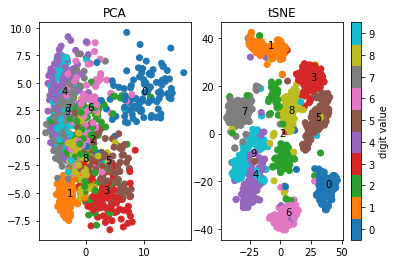

In [64]:
ax = plt.subplot("121")
ax.set_title("PCA")

plt.scatter(re_data_pca[:,0], re_data_pca[:,1], c=target_np, cmap=plt.cm.get_cmap('tab10', 10))
#plt.colorbar(ticks=range(10), label='digit value')
#plt.clim(-0.5, 9.5)
for i in range(10):
    plt.text(re_data_pca[target_np == i, 0].mean(),
            re_data_pca[target_np == i, 1].mean(),
            str(i))
    
ax = plt.subplot("122")
ax.set_title("tSNE")

plt.scatter(re_data_tsne[:,0], re_data_tsne[:,1], c=target_np, cmap=plt.cm.get_cmap('tab10', 10))
plt.colorbar(ticks=range(10), label='digit value')
plt.clim(-0.5, 9.5)
for i in range(10):
    plt.text(re_data_tsne[target_np == i, 0].mean(),
            re_data_tsne[target_np == i, 1].mean(),
            str(i))

#plt.savefig('1-7.pdf',dpi=300, format='pdf')

## Problem 1 - Question 8 - Dimensionality Reduction on Other Hidden Layers

In [16]:
# run a test loop
example_num = 1024
batch_num = example_num/test_batch_size # Limiting the number of test examples


test_loss = 0
correct = 0

for batch_idx, (img_data, target) in enumerate(test_loader):
    img_data, target = Variable(img_data, volatile=True), Variable(target)
    img_data = img_data.view(-1, 28 * 28)
    net_out, l5_out,l4_out,l3_out,l2_out,_ = net(img_data)
    # sum up batch loss
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
    correct += pred.eq(target.data).sum()
    if batch_idx == batch_num-1:
        break
    
    
#test_loss /= len(test_loader.dataset)
test_loss /= example_num
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, example_num,
100. * correct / example_num))



Test set: Average loss: 0.0046, Accuracy: 1002/1024 (98%)



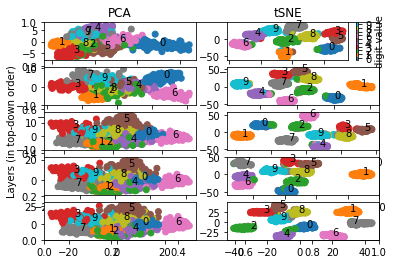

In [17]:
l_out = [l2_out.data.numpy(), l3_out.data.numpy(), l4_out.data.numpy(), l5_out.data.numpy(), net_out.data.numpy()]
target_np = target.data.numpy()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Layers (in top-down order)')

for idx in range(5):
    large_data = l_out[idx]
    pca = PCA(n_components=2).fit(large_data)
    re_data_pca = pca.transform(large_data)
    re_data_tsne = TSNE(n_components=2).fit_transform(large_data)

    ax = fig.add_subplot(5,2,2*idx+1)
    if idx==0:
        ax.set_title("PCA")

    plt.scatter(re_data_pca[:,0], re_data_pca[:,1], c=target_np, cmap=plt.cm.get_cmap('tab10', 10))
    #plt.colorbar(ticks=range(10), label='digit value')
    #plt.clim(-0.5, 9.5)
    for digit in range(10):
        plt.text(re_data_pca[target_np == digit, 0].mean(),
                re_data_pca[target_np == digit, 1].mean(),
                str(digit))
    
    ax = fig.add_subplot(5,2,2*idx+2)

    plt.scatter(re_data_tsne[:,0], re_data_tsne[:,1], c=target_np, cmap=plt.cm.get_cmap('tab10', 10))
    if idx==0:
        ax.set_title("tSNE")
        plt.colorbar(ticks=range(10), label='digit value')
    plt.clim(-0.5, 9.5)
    for digit in range(10):
        plt.text(re_data_tsne[target_np == digit, 0].mean(),
                re_data_tsne[target_np == digit, 1].mean(),
                str(digit))
plt.savefig('1-8.pdf',dpi=300, format='pdf')